<a href="https://colab.research.google.com/github/HappySage2004/Gender-Bias-NLP/blob/main/main%20analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/df.csv")

In [ ]:
df.drop("Unnamed: 0",axis=1,inplace=True)

In [ ]:
df.head()

,Text_1,Text_2,label
0,From the very ancient periods men used to appl...,Men and women of all ages participate in this ...,0
1,So he used sharp stones and bones to loosen th...,Can you imagine a world in which we cannot run...,1
2,"In a closed electric circuit, the electric cur...",Here is a diagram to show what is really happe...,0
3,She will not be able to understand all these a...,He must possess all the qualifications necessa...,0
4,Humanism - the concept that man is the measure...,"Again , he spends his earned money to buy esse...",0


In [ ]:
df.head()

,Text_1,Text_2,label
0,From the very ancient periods men used to appl...,Men and women of all ages participate in this ...,0
1,So he used sharp stones and bones to loosen th...,Can you imagine a world in which we cannot run...,1
2,"In a closed electric circuit, the electric cur...",Here is a diagram to show what is really happe...,0
3,She will not be able to understand all these a...,He must possess all the qualifications necessa...,0
4,Humanism - the concept that man is the measure...,"Again , he spends his earned money to buy esse...",0


In [ ]:
y = df['label'].values
y

array([0, 1, 0, ..., 0, 1, 0])

In [ ]:
y.shape

(155951,)

In [ ]:
df = df.drop(['label'], axis=1)

In [ ]:
df.head()

,Text_1,Text_2
0,From the very ancient periods men used to appl...,Men and women of all ages participate in this ...
1,So he used sharp stones and bones to loosen th...,Can you imagine a world in which we cannot run...
2,"In a closed electric circuit, the electric cur...",Here is a diagram to show what is really happe...
3,She will not be able to understand all these a...,He must possess all the qualifications necessa...
4,Humanism - the concept that man is the measure...,"Again , he spends his earned money to buy esse..."


In [ ]:
x = df[:].values
x.shape

(155951, 2)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [ ]:
y_train.shape

(93570,)

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 31.5 MB/s 
     |████████████████████████████████| 163 kB 74.2 MB/s 
     |████████████████████████████████| 7.6 MB 58.7 MB/s 


In [ ]:
max_length = 512# Maximum length of input sentence to the model.
batch_size = 128
epochs = 2


In [ ]:
class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        sentence_pairs: Array of premise and hypothesis input sentences.
        labels: Array of labels.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the labels.

    Returns:
        Tuples `([input_ids, attention_mask, `token_type_ids], labels)`
        (or just `[input_ids, attention_mask, `token_type_ids]`
         if `include_targets=False`)
    """

    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)



In [ ]:
import transformers
# Create the model under a distribution strategy scope.
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Encoded token ids from BERT tokenizer.
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
    # Token type ids are binary masks identifying different sequences in the model.
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids"
    )
    # Loading pretrained BERT model.
    bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
    # Freeze the BERT model to reuse the pretrained features without modifying them.
    bert_model.trainable = False

    bert_output = bert_model.bert(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )
    sequence_output = bert_output.last_hidden_state
    pooled_output = bert_output.pooler_output
    # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
    bi_lstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True)
    )(sequence_output)
    # Applying hybrid pooling approach to bi_lstm sequence output.
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)
    output = tf.keras.layers.Dense(2, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks, token_type_ids], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )


print(f"Strategy: {strategy}")
model.summary()


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7f116d0a75d0>
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',        

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train1 = to_categorical(y_train)
y_val1 = to_categorical(y_val)

In [ ]:
train_data = BertSemanticDataGenerator(
    X_train,
    y_train1,
    batch_size=batch_size,
    shuffle=True,
)
valid_data = BertSemanticDataGenerator(
    X_val[0:5000],
    y_val1[0:5000],
    batch_size=batch_size,
    shuffle=False,
)


In [ ]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=2,
    use_multiprocessing=True,
    workers=-1,
)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch 1/2
731/731 [==============================] - ETA: 0s - loss: 0.1153 - acc: 0.9487

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


731/731 [==============================] - 5734s 8s/step - loss: 0.1153 - acc: 0.9487 - val_loss: 0.0172 - val_acc: 0.9957
Epoch 2/2
731/731 [==============================] - 5706s 8s/step - loss: 0.0043 - acc: 0.9990 - val_loss: 3.9109e-04 - val_acc: 0.9999


In [ ]:

test_data = BertSemanticDataGenerator(
    X_test,
    y_test,
    batch_size=batch_size,
    shuffle=False,
)


In [ ]:
print(test_data)

In [ ]:
from tensorflow import keras

In [ ]:

model.save("/content/drive/MyDrive/bert_model")




In [ ]:
# Option 1: Load with the custom_object argument.
loaded_1 = keras.models.load_model(
    "/content/drive/MyDrive/bert_model", custom_objects={"CustomModel": model}
)

In [ ]:
f=loaded_1.predict(valid_data)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


39/39 [==============================] - 200s 5s/step


In [ ]:
from sklearn.metrics import accuracy_score
yp = np.argmax(f,axis=1)
accuracy_score(y_val[0:len(yp)],yp)

1.0

In [ ]:
f

array([[3.0845938e-05, 9.9996912e-01],
       [1.6442704e-04, 9.9983549e-01],
       [2.9744791e-05, 9.9997020e-01],
       ...,
       [1.8608091e-04, 9.9981397e-01],
       [3.5958208e-05, 9.9996400e-01],
       [1.1027207e-04, 9.9988973e-01]], dtype=float32)

In [ ]:
from collections import Counter
Counter(np.argmax(f,axis=1))

Counter({1: 15038, 0: 16066})

In [ ]:
y_test

array([1, 1, 1, ..., 0, 1, 0])

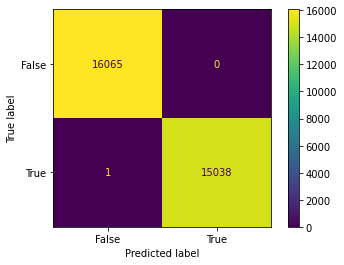

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test[0:len(yp)],yp)
import matplotlib.pyplot as plt
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
testdf = pd.read_csv("/content/Test(1).csv")
testdf.head()

,Unnamed: 0,Text_1,Text_2
0,0,Man is mortal. Everyone has to die some day or...,India won her independence from the British .
1,1,"If , any day , the child does not wet the bed ...",. Rani said conservation of biodiversity start...
2,2,Taking effective and preventive measures again...,"Side by side , she should teach the family mem..."
3,3,She has to shoulder and manage various respons...,"In such case , he can use his scarce means to ..."
4,4,On the other hand a civil case is always lodge...,We saw that the customs of the tribe as unders...


In [ ]:
testdf.drop("Unnamed: 0",axis=1,inplace=True)

In [ ]:
testdf.head()

,Text_1,Text_2
0,Man is mortal. Everyone has to die some day or...,India won her independence from the British .
1,"If , any day , the child does not wet the bed ...",. Rani said conservation of biodiversity start...
2,Taking effective and preventive measures again...,"Side by side , she should teach the family mem..."
3,She has to shoulder and manage various respons...,"In such case , he can use his scarce means to ..."
4,On the other hand a civil case is always lodge...,We saw that the customs of the tribe as unders...


In [ ]:
xt =testdf.values
yt = np.zeros(len(xt))

In [ ]:
yt.shape


(5000,)

In [ ]:
t_data = BertSemanticDataGenerator(
    xt,
    np.zeros(xt.shape),
    batch_size=batch_size,
    shuffle=False,
)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [ ]:
len(xt)

5000

In [ ]:
t_data

In [ ]:
len(xt[-8:])

8

In [ ]:
xt.shape

(5000, 2)

In [ ]:
f= BertSemanticDataGenerator(
    xt,
    np.zeros(xt.shape),
    batch_size=125,
    shuffle=False,
)

NameError: ignored

In [ ]:
r = loaded_1.predict(f)
r

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


40/40 [==============================] - 205s 5s/step


array([[3.1613116e-04, 9.9968386e-01],
       [6.0080648e-03, 9.9399191e-01],
       [8.5962117e-01, 1.4037886e-01],
       ...,
       [9.9702328e-01, 2.9767388e-03],
       [9.9977964e-01, 2.2034967e-04],
       [3.3034864e-03, 9.9669647e-01]], dtype=float32)

In [ ]:
5000/125

40.0

In [ ]:
yp = np.argmax(r,axis=1)
yp

array([1, 1, 0, ..., 0, 0, 1])

In [ ]:
len(yp)

5000

In [ ]:
4992/128

39.0

In [ ]:
from collections import Counter
Counter(yp)

Counter({1: 1824, 0: 3176})

In [ ]:
iddf = pd.read_csv("/content/test-data-for-participant",header=None)
iddf.shape

(5000, 2)

In [ ]:
iddf['label']=yp

In [ ]:
iddf

,0,1,label
0,838,889,1
1,905,1330,1
2,859,875,0
3,861,874,0
4,857,869,0
...,...,...,...
4995,847,898,0
4996,1236,1276,1
4997,851,889,0
4998,829,898,0


In [ ]:
iddf.to_csv("/content/finalsubmission.csv",header=False,index=False)